In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.feature_selection as fs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

### **1. Iportarea datelor CSV**

In [36]:
movies_df = pd.read_csv('../Data\Setul de date Filme.csv')
movies_df.head()

,title,year,runtime,certificate,genre,director,stars,rating,metascore,votes,gross
0,The Shawshank Redemption,1994,142,R,Drama,"['Frank Darabont', 'Tim Robbins', 'Morgan Free...","['Tim Robbins', 'Morgan Freeman', 'Bob Gunton'...",9.3,82.0,2780534,28.34
1,The Godfather,1972,175,R,"Crime, Drama","['Francis Ford Coppola', 'Marlon Brando', 'Al ...","['Marlon Brando', 'Al Pacino', 'James Caan', '...",9.2,100.0,1935895,134.97
2,Ramayana: The Legend of Prince Rama,1993,135,PG,"Animation, Action, Adventure","['Ram Mohan', 'Yûgô Sakô', 'Koichi Saski', 'Ar...","['Yûgô Sakô', 'Koichi Saski', 'Arun Govil', 'N...",9.2,NaN,12470,NaN
3,The Chaos Class,1975,87,NaN,"Comedy, Drama","['Ertem Egilmez', 'Kemal Sunal', 'Münir Özkul'...","['Kemal Sunal', 'Münir Özkul', 'Halit Akçatepe...",9.2,NaN,42018,NaN
4,Daman,2022,121,NaN,"Adventure, Drama","['Lenka Debiprasad', 'Vishal Mourya', 'Karan K...","['Vishal Mourya', 'Karan Kandhapan', 'Babushan...",9.1,NaN,13372,NaN


In [37]:
# Converts string to list
def convert_to_list(string):
    try:
        string = string.replace("[", "") # Remove opening brackets
        string = string.replace("]", "") # Remove closing brackets
        string = string.replace("'", "") # Remove ' characters
        li = string.split(", ")
    except AttributeError:
        return string
    return li

# Given an input list, for each element, finds the average rating of movies where the element is in col_name
def find_avg_rating(li, col_name):
    avg_ratings = []
    li = [str(x) for x in li]
    for elem in li:
        temp_df = movies_df[movies_df[col_name].astype(str).str.contains(elem)]
        avg_ratings.append(temp_df['rating'].mean())
    return avg_ratings

### **Preprocesarea datelor**

In [38]:
movies_df.dtypes

title           object
year            object
runtime          int64
certificate     object
genre           object
director        object
stars           object
rating         float64
metascore      float64
votes            int64
gross          float64
dtype: object

In [39]:
# Replace all empty cells with NaN
movies_df = movies_df.mask(movies_df == '')
# Standarize 'year' column as YYYY
if movies_df['year'].dtype == object:
    movies_df['year'] = movies_df['year'].map(lambda x: x[-4:])
# Change numerical features to appropriate numerical datatypes
movies_df['year'] = pd.to_numeric(movies_df['year'])
movies_df['runtime'] = pd.to_numeric(movies_df['runtime'])
movies_df['rating'] = pd.to_numeric(movies_df['rating'])
movies_df['metascore'] = pd.to_numeric(movies_df['metascore'])
movies_df['votes'] = pd.to_numeric(movies_df['votes'])
movies_df['gross'] = pd.to_numeric(movies_df['gross'])

In [40]:
# Convert director, stars and genre columns from strings to lists
movies_df['director'] = movies_df['director'].map(convert_to_list)
movies_df['stars'] = movies_df['stars'].map(convert_to_list)
movies_df['genre'] = movies_df['genre'].map(convert_to_list)

#### **Gestionarea valorilor lipsă**

In [41]:
# Print the percentages of NaN values for each column
display(movies_df.isnull().sum()*100/len(movies_df))

title           0.000000
year            0.000000
runtime         0.000000
certificate     3.614580
genre           0.000000
director        0.000000
stars           0.000000
rating          0.000000
metascore      20.032491
votes           0.000000
gross          28.774495
dtype: float64

#### **Modele de antrenament pentru predicția Metascore**

#### **Crearea de seturi de antrenament și testare**

In [42]:
# Create new dataframe where all rows with any missing values and all non-numerical columns are dropped
meta_df = movies_df.dropna()
meta_df = meta_df.select_dtypes(include='number')
X, y = meta_df.drop('metascore', axis=1), meta_df['metascore']
# Split data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=5)

#### **Regresia liniară Metascore**

In [43]:
#training_imdb = np.array(meta_df.loc[:, 'rating'].tolist(), dtype=np.float32).reshape(-1, 1)
#training_metascore = np.array(meta_df.loc[:, 'metascore'].tolist(), dtype=np.float32).reshape(-1, 1)

# Create a linear regression model
meta_lr = LinearRegression()
# Use forward elimination to select variables
sfs_lr = fs.SequentialFeatureSelector(meta_lr, direction='forward', tol=0.05, n_features_to_select='auto')
sfs_lr.fit(train_X, train_y)
# Print a list of selected variables
print(list(X.loc[:, sfs_lr.get_support()].columns))
# Transform X data to only contain selected variables
train_X_sel_lr = sfs_lr.transform(train_X)
test_X_sel_lr = sfs_lr.transform(test_X)
# Fit Linear Regression model using selected variables
meta_lr.fit(train_X_sel_lr, train_y)
# Predict values for test set
test_y_pred_lr = meta_lr.predict(test_X_sel_lr)
# meta_linear.fit(training_imdb, training_metascore)

['rating']


#### **Metascore K-Cei mai apropiați vecini**

In [44]:
# Create a KNN regression model
meta_knn = KNeighborsRegressor()
# Use forward elimination to select variables
sfs_knn = fs.SequentialFeatureSelector(meta_knn, direction='forward', tol=0.05, n_features_to_select='auto')
sfs_knn.fit(train_X, train_y)
# Print a list of selected variables
print(list(X.loc[:, sfs_knn.get_support()].columns))
# Transform X data to only contain selected variables
train_X_sel_knn = sfs_knn.transform(train_X)
test_X_sel_knn = sfs_knn.transform(test_X)
# Perform a grid search with cross validation to select the most performant k value
k_grid = {'n_neighbors': np.arange(1, np.floor(np.sqrt(len(train_X))), dtype=int)}
meta_knn_gscv = GridSearchCV(meta_knn, k_grid, cv=5)
meta_knn_gscv.fit(train_X_sel_knn, train_y)
# Check the most performant k value found by grid search
print(meta_knn_gscv.best_params_)
# Set k value of KNN regression model to found K value
meta_knn = KNeighborsRegressor(n_neighbors=meta_knn_gscv.best_params_['n_neighbors'])
meta_knn.fit(train_X_sel_knn, train_y)
# Predict values for test set
test_y_pred_knn = meta_knn.predict(test_X_sel_knn)

['rating']
{'n_neighbors': 70}


#### **Comparație de model**

In [45]:
# Compute mean squared error and R^2 scores for the linear regression model
meta_mse_lr = mean_squared_error(test_y, test_y_pred_lr)
meta_r2_lr = r2_score(test_y, test_y_pred_lr)

# Compute mean squared error and R^2 scores for the KNN regression model
meta_mse_knn = mean_squared_error(test_y, test_y_pred_knn)
meta_r2_knn = r2_score(test_y, test_y_pred_knn)

print("Linear Regression - MSE: {}, R^2: {}".format(meta_mse_lr, meta_r2_lr))
print("K-Nearest Neighbors - MSE: {}, R^2: {}".format(meta_mse_knn, meta_r2_knn))

Linear Regression - MSE: 149.70511373420692, R^2: 0.5007831093926833
K-Nearest Neighbors - MSE: 150.47799022573147, R^2: 0.4982058226901902


Modelul de regresie KNN are performanțe puțin mai bune cu o eroare pătratică medie mai mică și o valoare R^2 mai mare. Deci, modelul de regresie KNN va fi utilizat pentru a imputa valorile Metascore.

In [46]:
# Compute predicted values using KNN regression model for all rows and store it in new column 'pred_metascore'
movies_df['pred_metascore'] = meta_knn.predict(np.array(movies_df['rating']).reshape(-1, 1))
# Fill NaN values in original 'metascore' column with corresponding 'pred_metascore' value
movies_df['metascore'] = movies_df['metascore'].fillna(movies_df['pred_metascore'])

#### **Modele de instruire pentru câștigul brut**

#### **Crearea de seturi de antrenament și testare**

In [47]:
# Split columns into input and output variables
X, y = meta_df.drop('gross', axis=1), meta_df['gross']
# Split data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=5)

#### **Regresia liniară a veniturilor brute**

In [48]:
# Create a linear regression model
gross_lr = LinearRegression()
# Use forward elimination to select variables
sfs_lr = fs.SequentialFeatureSelector(gross_lr, direction='forward', tol=0.05, n_features_to_select='auto')
sfs_lr.fit(train_X, train_y)
# Print a list of selected variables
print(list(X.loc[:, sfs_lr.get_support()].columns))
# Transform X data to only contain selected variables
train_X_sel_lr = sfs_lr.transform(train_X)
test_X_sel_lr = sfs_lr.transform(test_X)
# Fit Linear Regression model using selected variables
gross_lr.fit(train_X_sel_lr, train_y)
# Predict values for test set
test_y_pred_lr = gross_lr.predict(test_X_sel_lr)

['votes']


#### **Câștiguri brute K-Cei mai apropiați vecini**

In [49]:
# Create a KNN regression model
gross_knn = KNeighborsRegressor()
# Use forward elimination to select variables
sfs_knn = fs.SequentialFeatureSelector(gross_knn, direction='forward', tol=0.05, n_features_to_select='auto')
sfs_knn.fit(train_X, train_y)
# Print a list of selected variables
print(list(X.loc[:, sfs_knn.get_support()].columns))
# Transform X data to only contain selected variables
train_X_sel_knn = sfs_knn.transform(train_X)
test_X_sel_knn = sfs_knn.transform(test_X)
# Perform a grid search with cross validation to select the most performant k value
k_grid = {'n_neighbors': np.arange(1, np.floor(np.sqrt(len(train_X))), dtype=int)}
gross_knn_gscv = GridSearchCV(gross_knn, k_grid, cv=5)
gross_knn_gscv.fit(train_X_sel_knn, train_y)
# Check the most performant k value found by grid search
print(gross_knn_gscv.best_params_)
# Set k value of KNN regression model to found K value
gross_knn = KNeighborsRegressor(n_neighbors=gross_knn_gscv.best_params_['n_neighbors'])
gross_knn.fit(train_X_sel_knn, train_y)
# Predict values for test set
test_y_pred_knn = gross_knn.predict(test_X_sel_knn)

['votes']
{'n_neighbors': 67}


#### **Comparație de model**

In [50]:
# Compute mean squared error and R^2 scores for the linear regression model
gross_mse_lr = mean_squared_error(test_y, test_y_pred_lr)
gross_r2_lr = r2_score(test_y, test_y_pred_lr)

# Compute mean squared error and R^2 scores for the KNN regression model
gross_mse_knn = mean_squared_error(test_y, test_y_pred_knn)
gross_r2_knn = r2_score(test_y, test_y_pred_knn)

print("Linear Regression - MSE: {}, R^2: {}".format(gross_mse_lr, gross_r2_lr))
print("K-Nearest Neighbors - MSE: {}, R^2: {}".format(gross_mse_knn, gross_r2_knn))

Linear Regression - MSE: 3023.9001045960417, R^2: 0.30846952959416596
K-Nearest Neighbors - MSE: 2658.022211867578, R^2: 0.3921415103203314


Din nou, modelul de regresie KNN depășește modelul de regresie liniară cu un MSE mai mic și R^2 mai mare. Deci, modelul de regresie KNN va fi folosit și pentru a imputa valoarea câștigului brut.

In [51]:
# Compute predicted values using KNN regression model for all rows and store it in new column 'pred_gross'
movies_df['pred_gross'] = gross_knn.predict(np.array(movies_df['votes']).reshape(-1, 1))
# Fill NaN values in original 'gross' column with corresponding 'pred_gross' value
movies_df['gross'] = movies_df['gross'].fillna(movies_df['pred_gross'])

### **Analiza exploratorie a datelor**

In [52]:
display(movies_df.dtypes)
movies_df.describe()

title              object
year                int64
runtime             int64
certificate        object
genre              object
director           object
stars              object
rating            float64
metascore         float64
votes               int64
gross             float64
pred_metascore    float64
pred_gross        float64
dtype: object

,year,runtime,rating,metascore,votes,gross,pred_metascore,pred_gross
count,9849.000000,9849.000000,9849.000000,9849.000000,9.849000e+03,9849.000000,9849.000000,9849.000000
mean,2001.387958,110.578333,6.723342,59.816676,9.083541e+04,33.329028,59.420176,33.813455
std,18.492942,21.881521,0.813738,16.707027,1.668340e+05,58.012567,12.951822,39.951655
min,1915.000000,45.000000,4.900000,7.000000,1.000000e+04,0.000000,32.757143,4.965373
25%,1994.000000,96.000000,6.100000,47.957143,1.683600e+04,5.970000,48.685714,11.550000
50%,2007.000000,106.000000,6.700000,61.000000,3.405200e+04,13.740000,58.428571,17.050448
75%,2015.000000,120.000000,7.300000,71.700000,9.051300e+04,36.810000,69.771429,39.253582
max,2023.000000,439.000000,9.300000,100.000000,2.780534e+06,936.660000,83.285714,248.755970


#### **Trasarea datelor**

##### **Setarea stilului de diagramă**

In [53]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.set_context(rc = {'patch.linewidth': 0.0})
try:
    mpl.style.reload_library()
    plt.style.use('rose-pine-matplotlib-main//themes//rose-pine-moon.mplstyle')
    print("Using Rose Pine Moon theme found at https://github.com/h4pZ/rose-pine-matplotlib")
except:
    print("Using default matplotlib style")

Using default matplotlib style


**Oamenii preferă filme mai lungi sau mai scurte?**

Corelația dintre durata filmului și ratingul IMDb: 0.3383544519476287


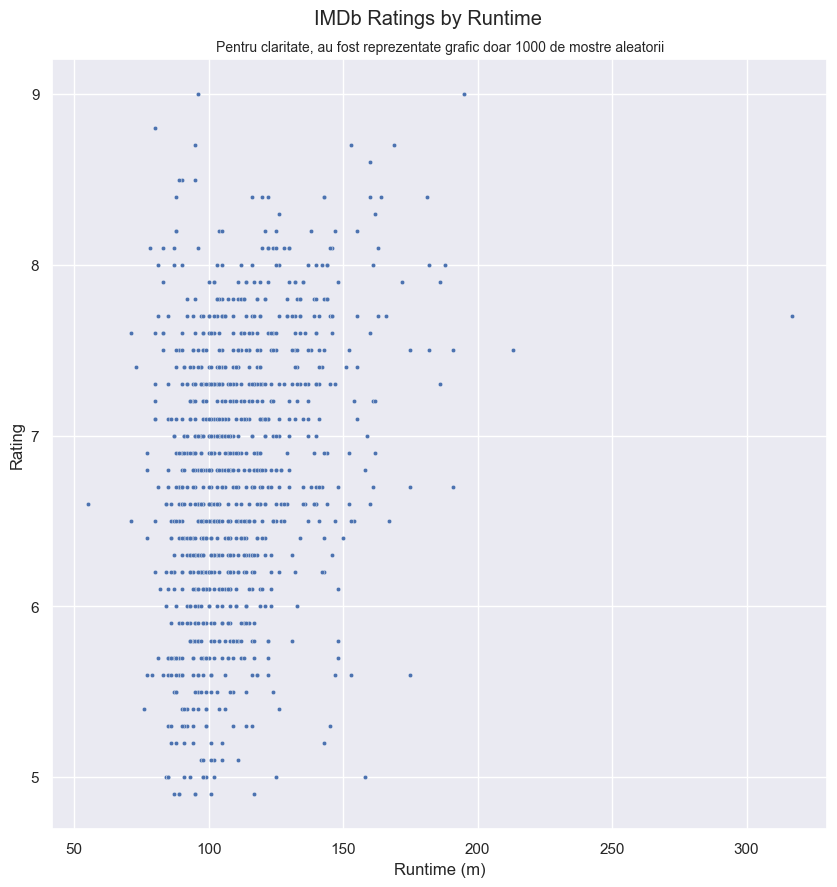

In [54]:
sample_size=1000
random_sample=movies_df.sample(n=sample_size,
                               axis=0,
                               random_state=1)
rating_scatterplot = sns.scatterplot(x=random_sample['runtime'], y=random_sample['rating'], s=10)
rating_scatterplot.set(xlabel='Runtime (m)',
                       ylabel='Rating',)
plt.suptitle('IMDb Ratings by Runtime',
             y=0.93);
plt.title('Pentru claritate, au fost reprezentate grafic doar 1000 de mostre aleatorii',
          loc='center',
          fontsize=10);
print("Corelația dintre durata filmului și ratingul IMDb: {}".format(movies_df['runtime'].corr(movies_df['rating'])))

**Care genuri de filme sunt cele mai bine evaluate?**

In [55]:
unique_genres = list(set(sum(movies_df['genre'], [])))
genre_avg = find_avg_rating(unique_genres, "genre")
genre_df = pd.DataFrame({'genre': unique_genres, 'avg_rating': genre_avg}).sort_values(by=['avg_rating'])

genre_count = pd.Series(sum(movies_df['genre'], []))
genre_order = genre_count.value_counts()

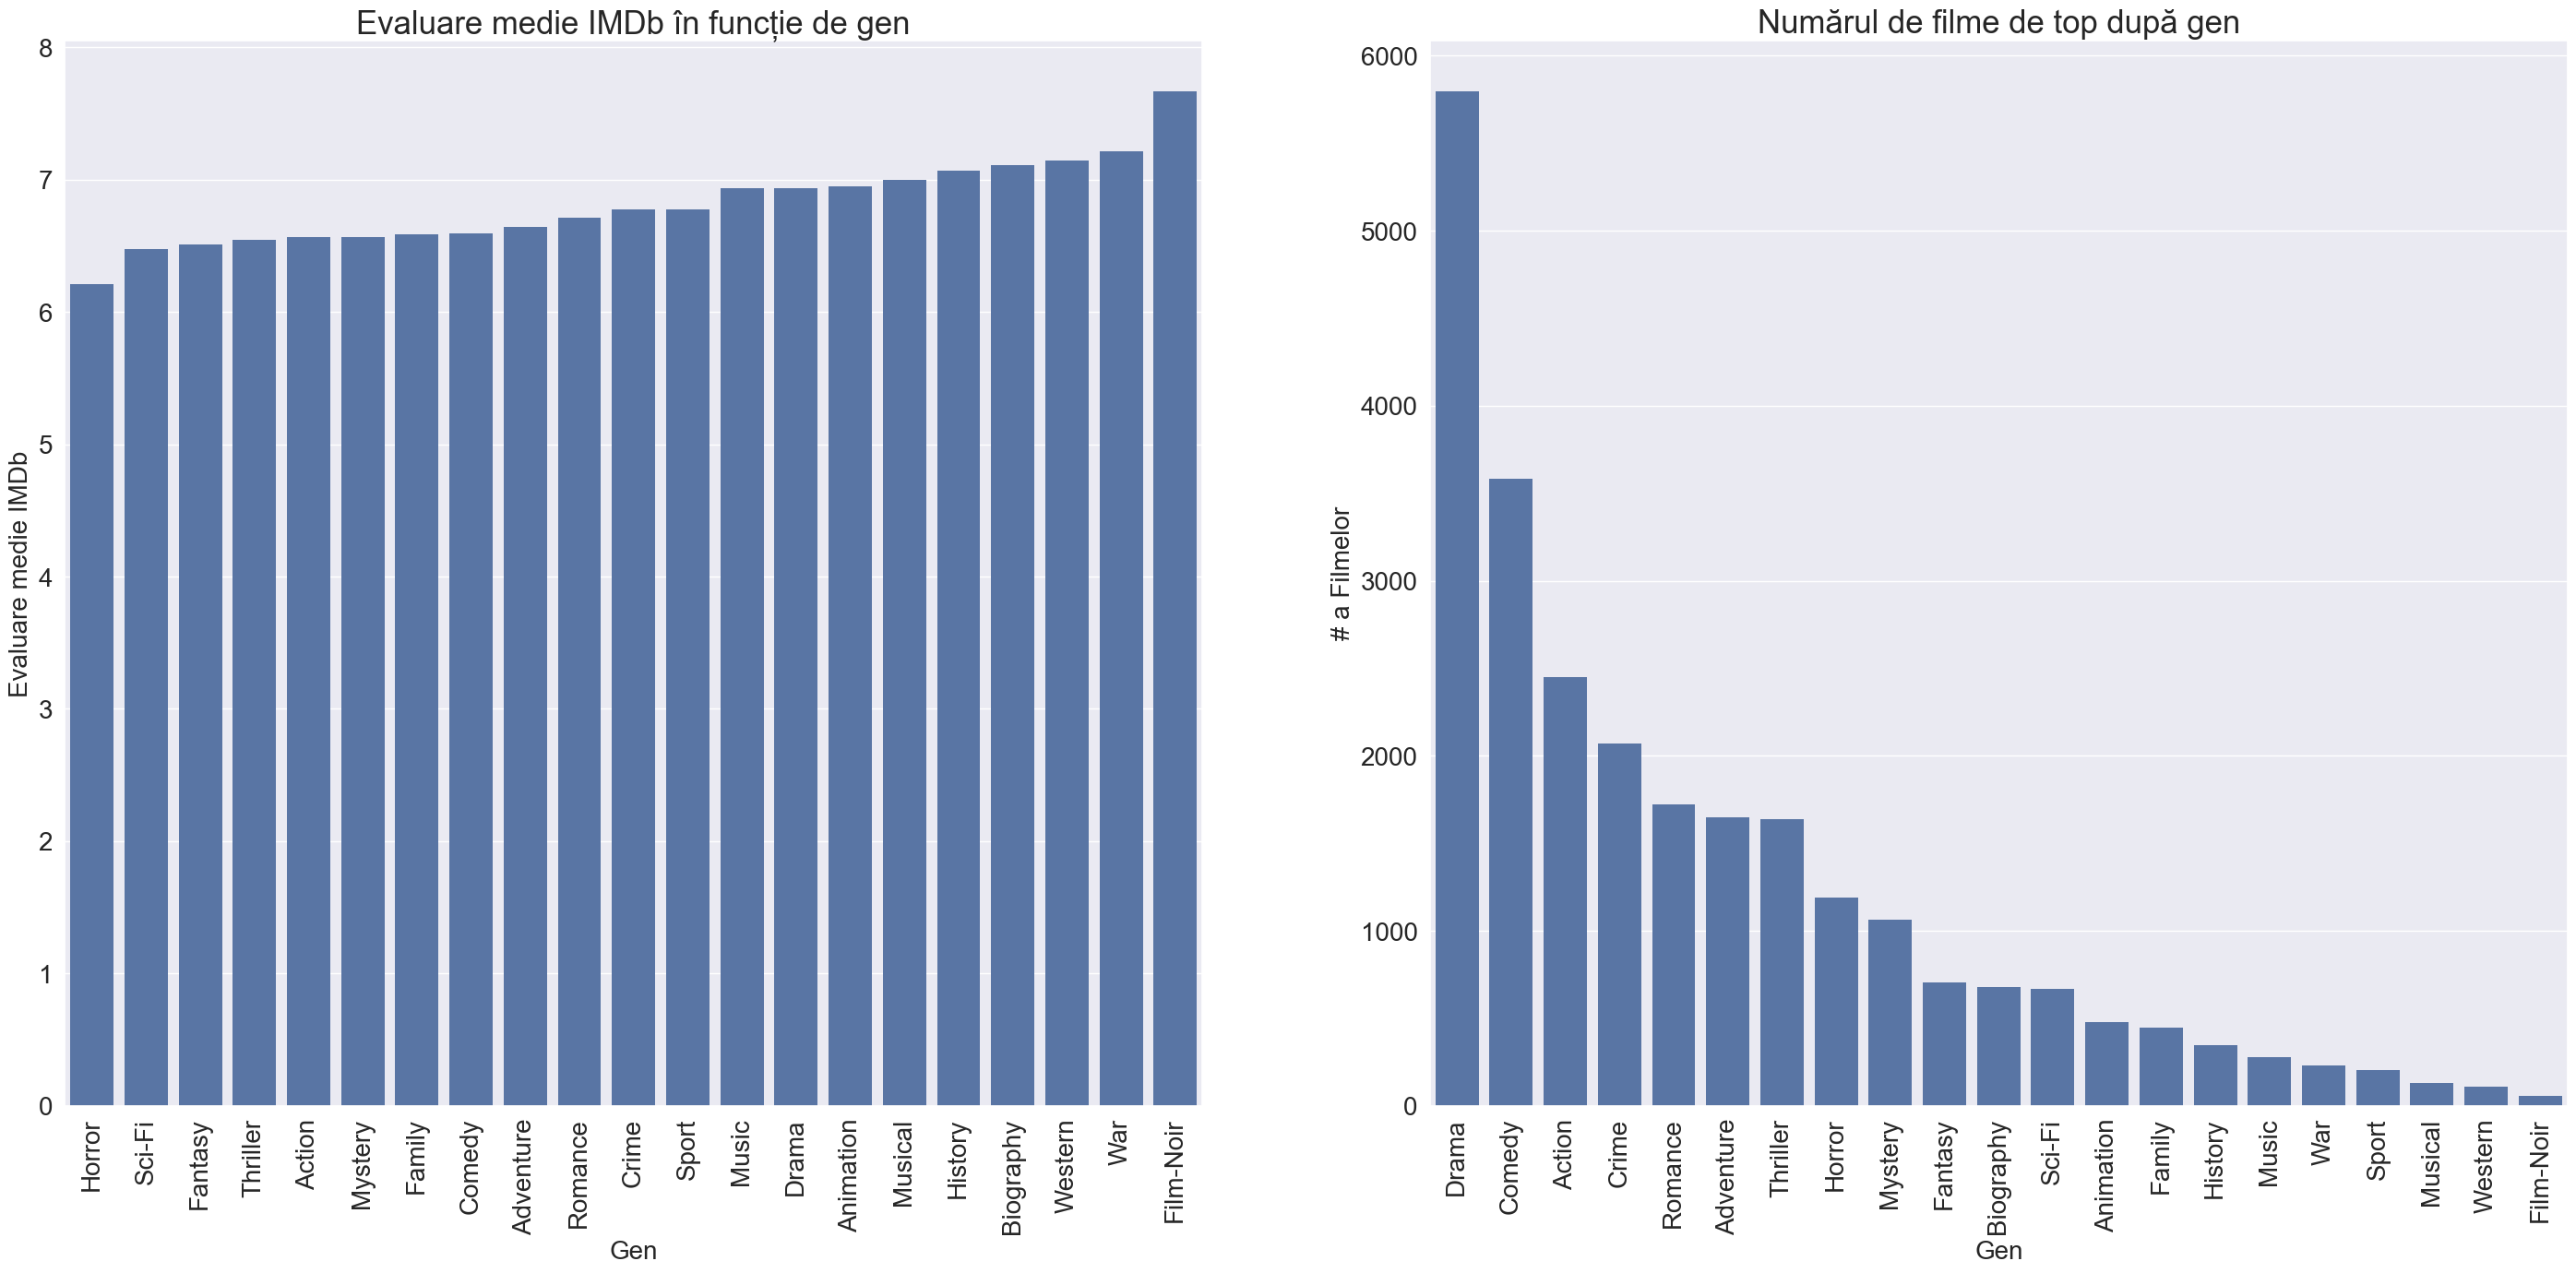

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(35, 15), gridspec_kw={'hspace': 0.5})

sns.barplot(data=genre_df, x=genre_df['genre'], y=genre_df['avg_rating'], ax=axes[0])
sns.barplot(x = genre_order.index, y = genre_order, ax=axes[1])

axes[0].tick_params(axis='x', rotation=90, labelsize=20)
axes[1].tick_params(axis='x', rotation=90, labelsize=20)

axes[0].tick_params(axis='y', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)

axes[0].set_xlabel('Gen', fontsize=20)
axes[0].set_ylabel('Evaluare medie IMDb', fontsize=20)
axes[0].set_title('Evaluare medie IMDb în funcție de gen', fontsize=25)

axes[1].set_xlabel('Gen', fontsize=20)
axes[1].set_ylabel('# a Filmelor', fontsize=20)
axes[1].set_title('Numărul de filme de top după gen', fontsize=25)

plt.show()

**Oamenii preferă filmele mai vechi sau mai noi?**

In [57]:
year_order = movies_df['year'].value_counts()

unique_years = list(movies_df['year'].unique())
year_ratings = find_avg_rating(unique_years, "year")
year_df = pd.DataFrame({'year': unique_years, 'avg_rating': year_ratings}).sort_values(by=['avg_rating'])

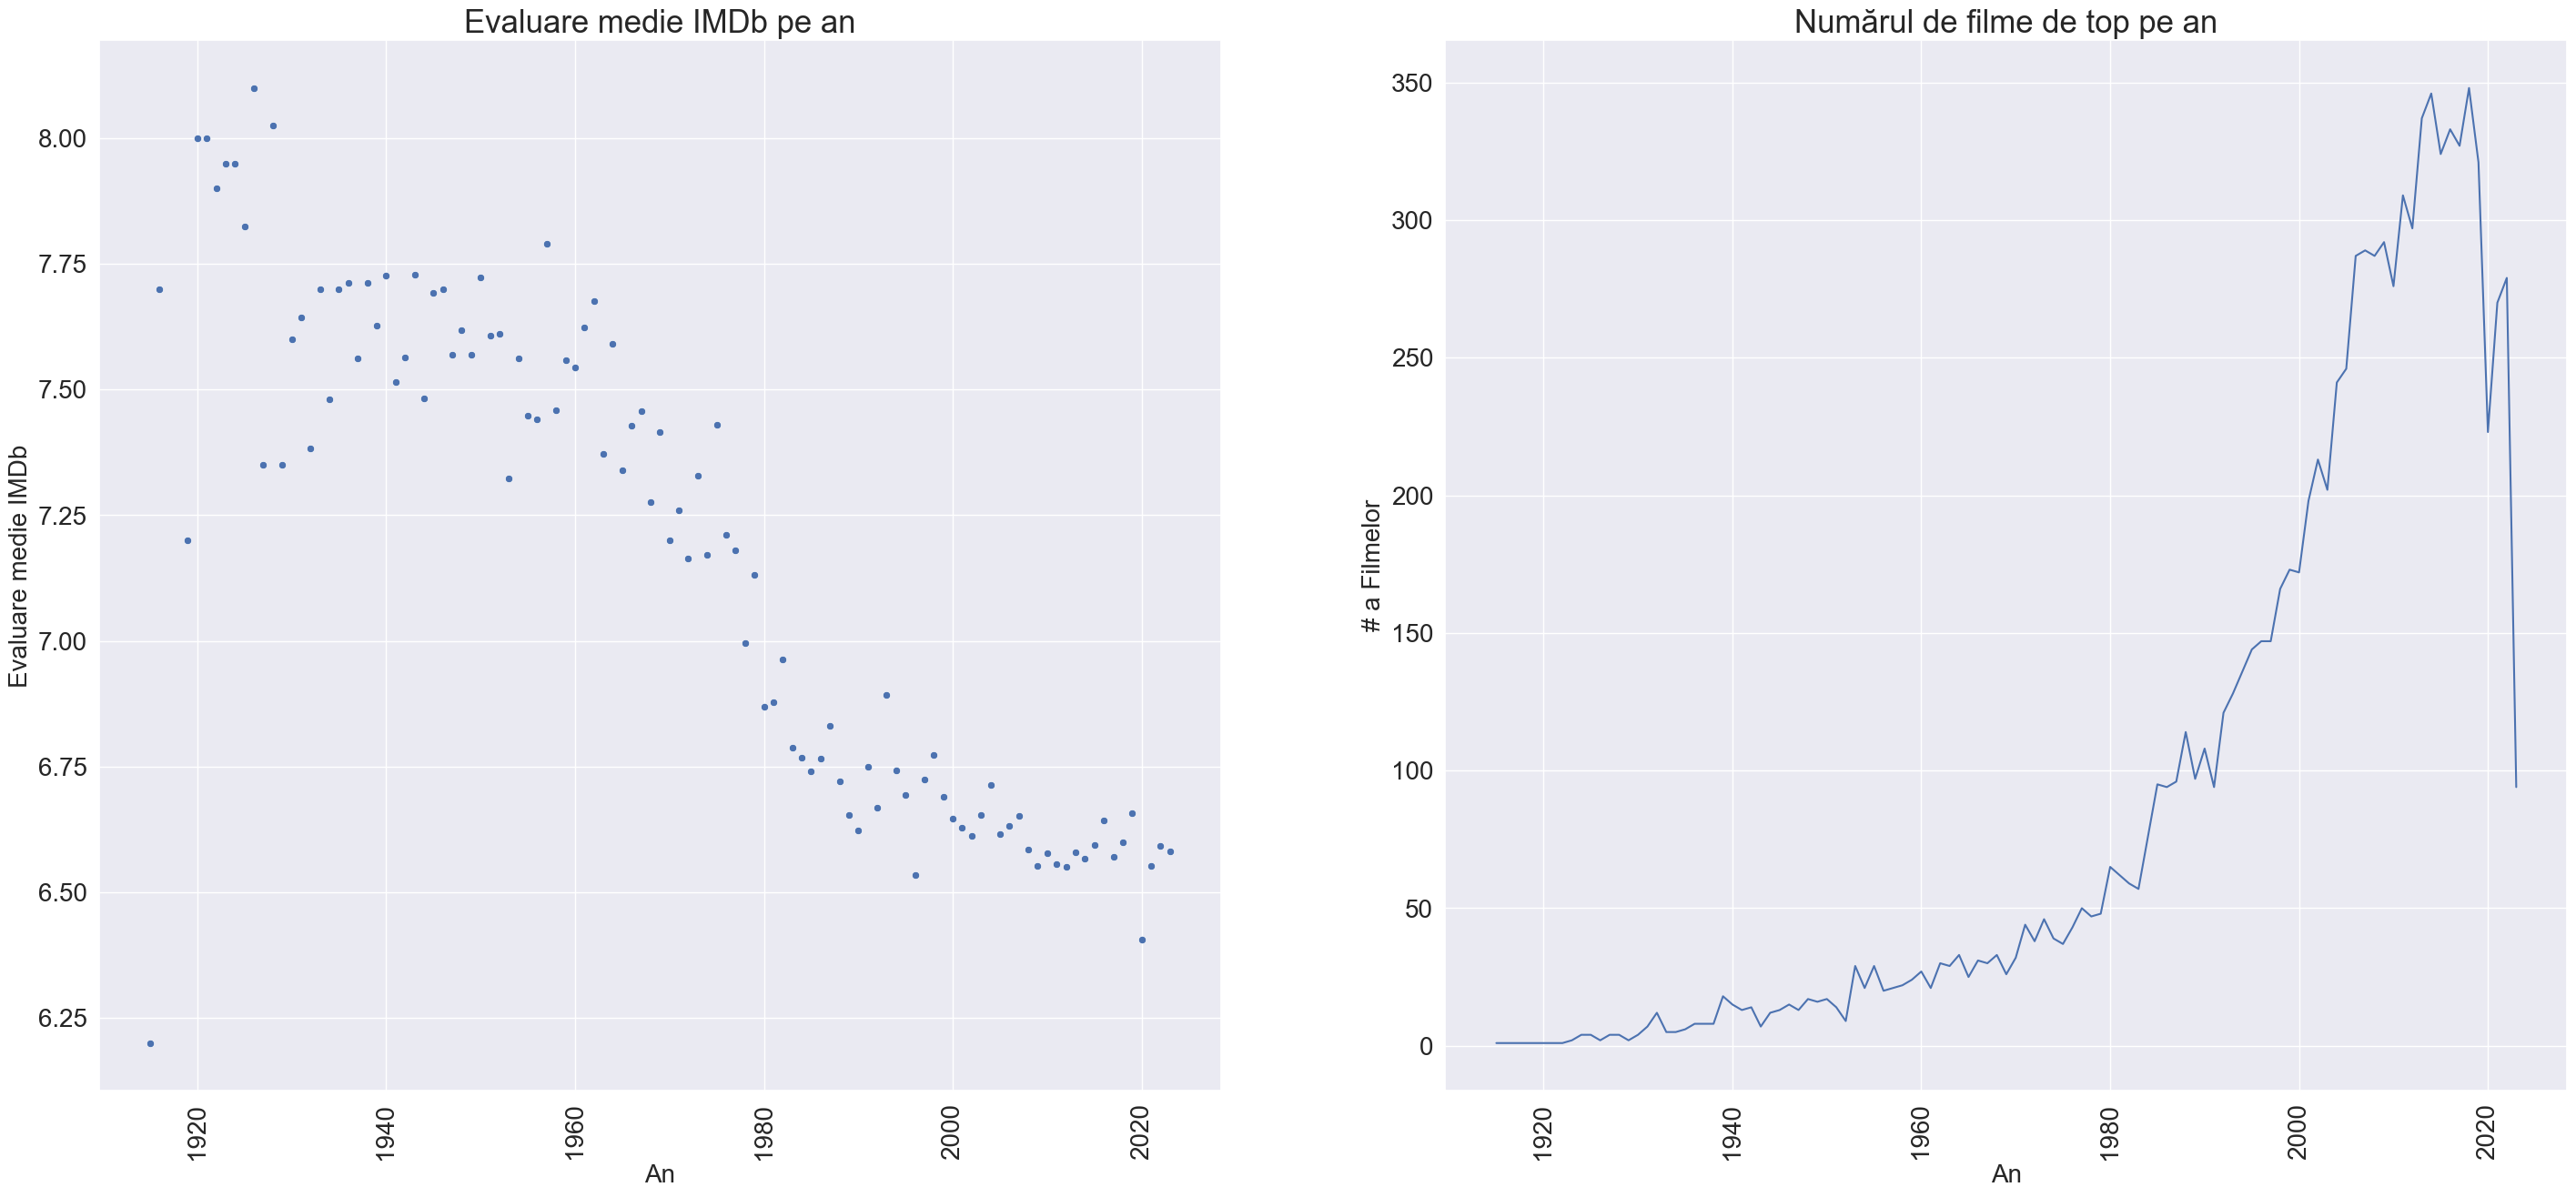

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(35, 15), gridspec_kw={'hspace': 0.5})

sns.scatterplot(data=year_df, x='year', y='avg_rating', ax=axes[0])
sns.lineplot(x = year_order.index, y = year_order, ax=axes[1])

axes[0].tick_params(axis='x', rotation=90, labelsize=20)
axes[1].tick_params(axis='x', rotation=90, labelsize=20)

axes[0].tick_params(axis='y', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)

axes[0].set_xlabel('An', fontsize=20)
axes[0].set_ylabel('Evaluare medie IMDb', fontsize=20)
axes[0].set_title('Evaluare medie IMDb pe an', fontsize=25)

axes[1].set_xlabel('An', fontsize=20)
axes[1].set_ylabel('# a Filmelor', fontsize=20)
axes[1].set_title('Numărul de filme de top pe an', fontsize=25)

plt.show()

**Care actori/actrițe apar în cele mai bune filme?**

In [59]:
stars_count = pd.Series(sum(movies_df['stars'], []))
stars_order = stars_count.value_counts()

unique_stars = stars_order[stars_order > 10].index
stars_avg = find_avg_rating(unique_stars, "stars")
stars_df = pd.DataFrame({'stars': unique_stars, 'avg_rating': stars_avg}).sort_values(by=['avg_rating']).dropna()

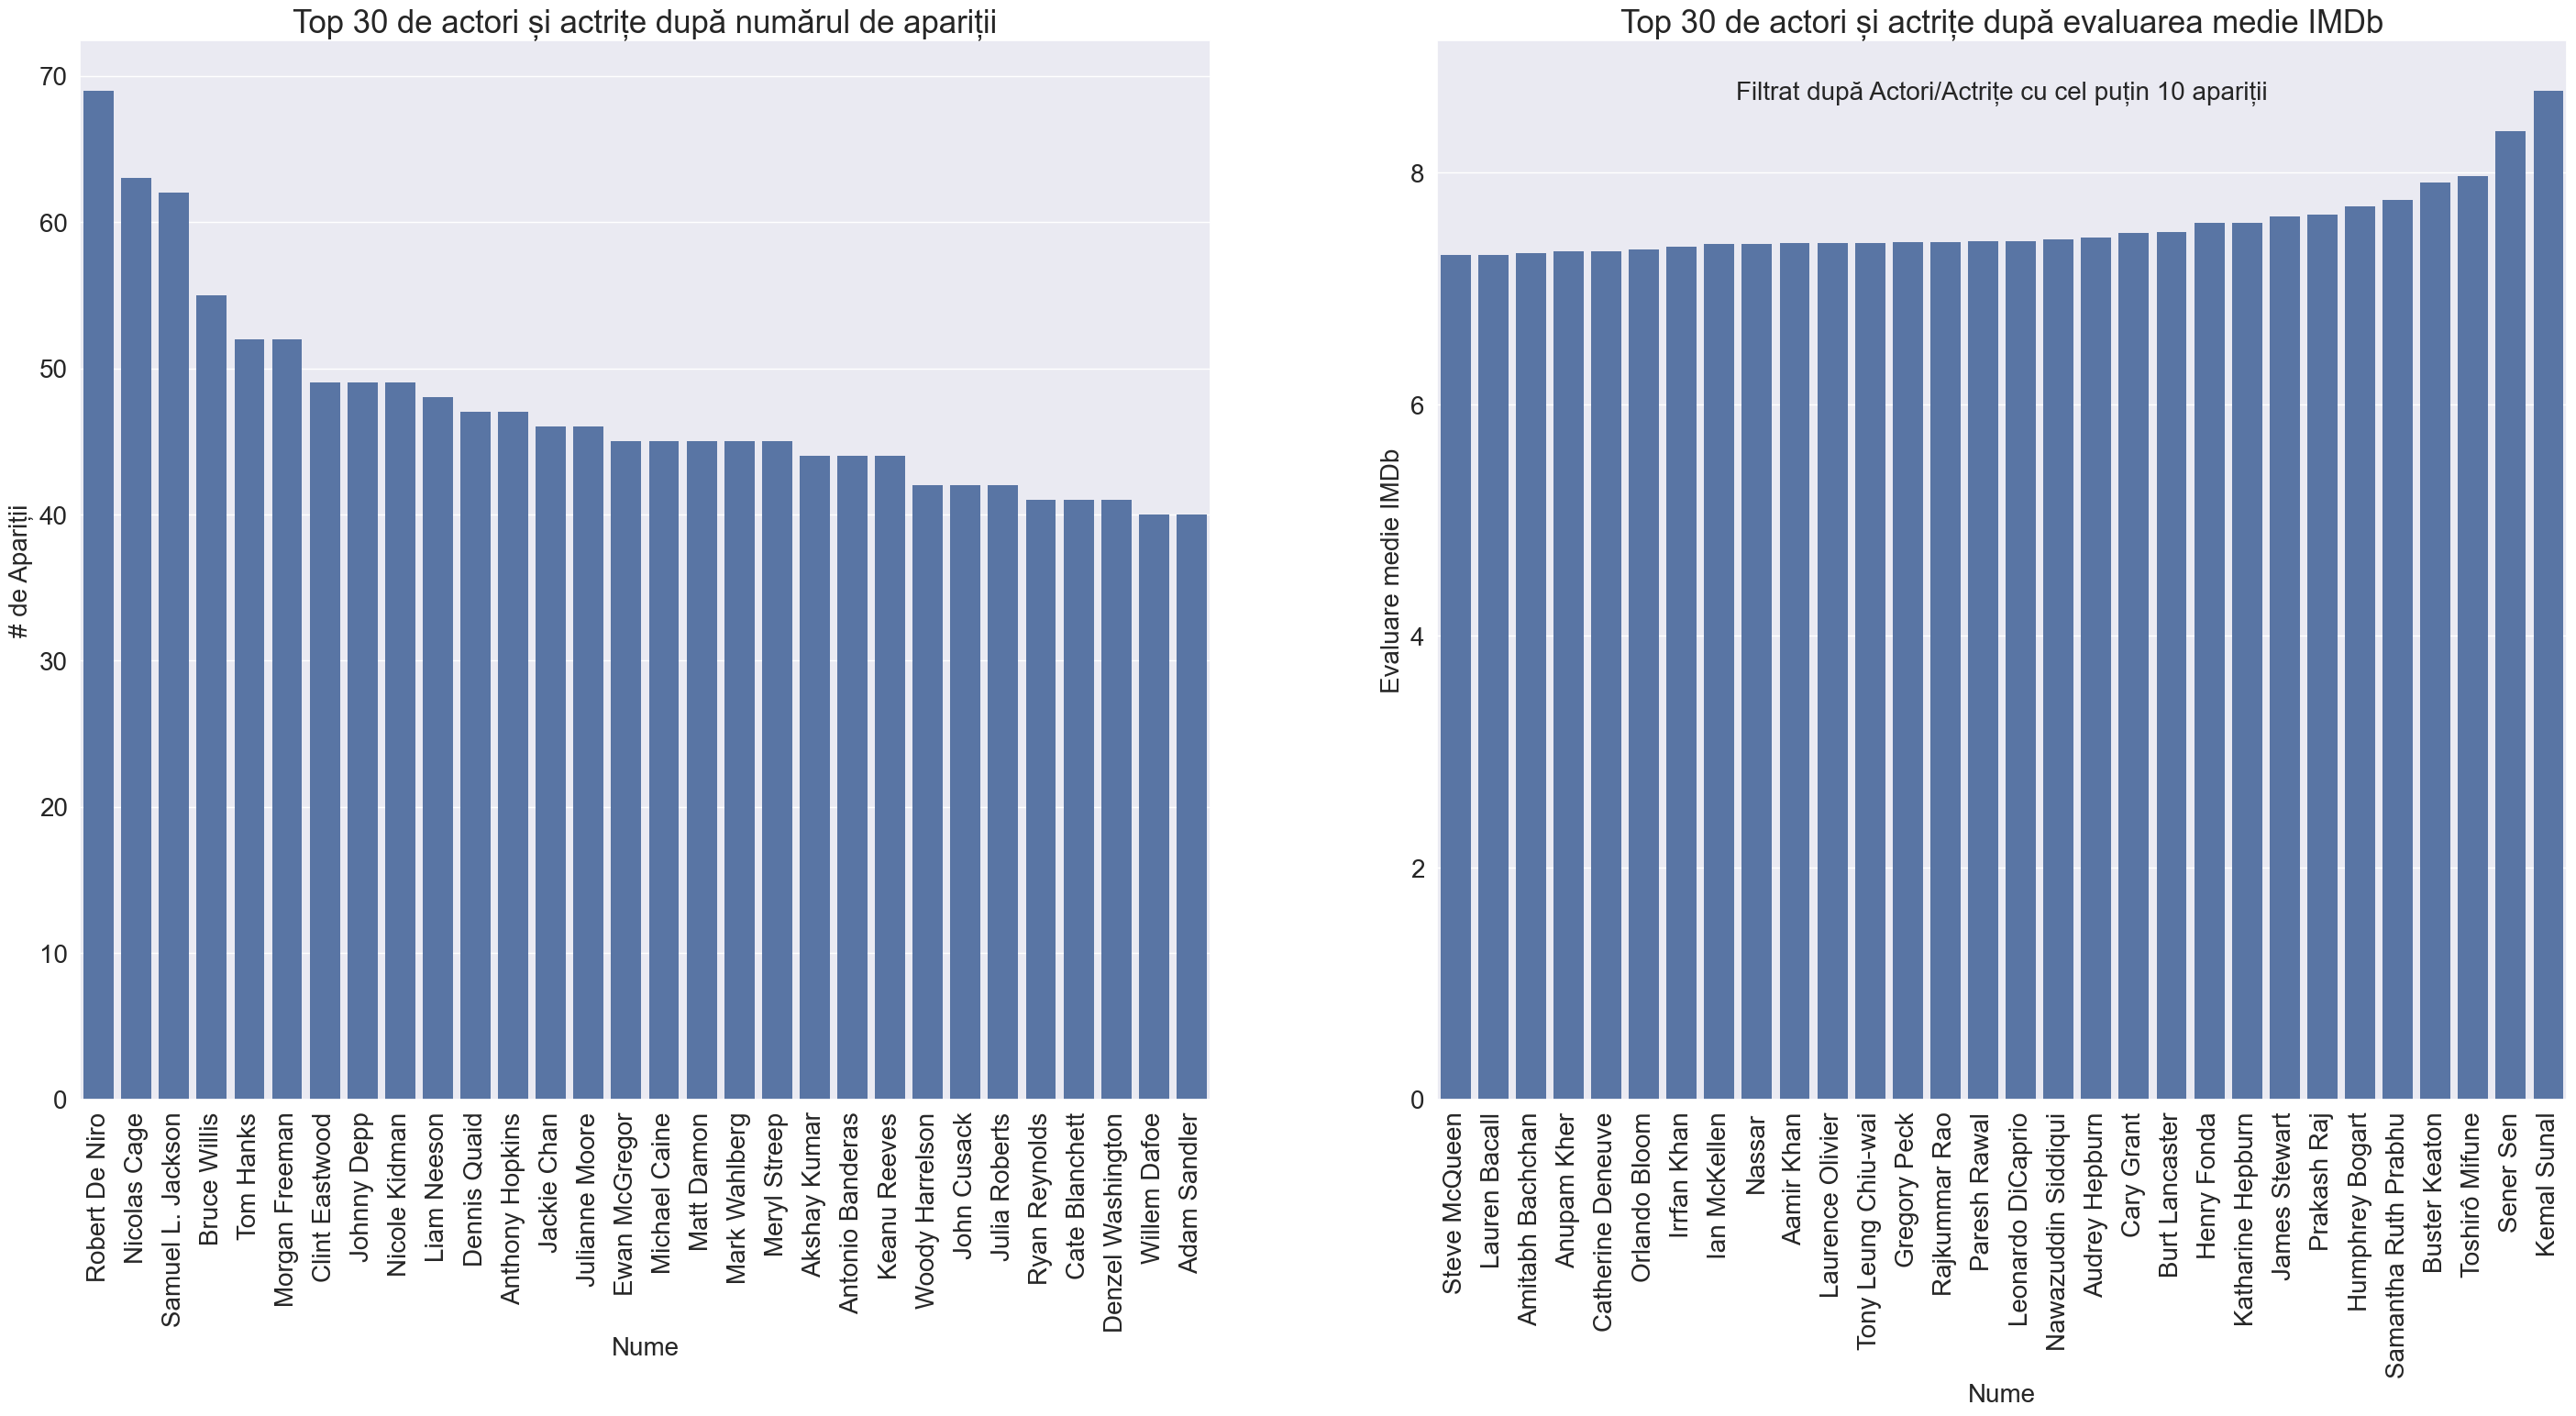

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(35, 15), gridspec_kw={'hspace': 0.5})

sns.barplot(x = stars_order[0:30].index, y = stars_order[0:30], ax=axes[0])
sns.barplot(data=stars_df[-30:], x='stars', y='avg_rating', ax=axes[1])

axes[0].tick_params(axis='x', rotation=90, labelsize=20)
axes[1].tick_params(axis='x', rotation=90, labelsize=20)

axes[0].tick_params(axis='y', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)

axes[0].set_xlabel('Nume', fontsize=20)
axes[0].set_ylabel('# de Apariții', fontsize=20)
axes[0].set_title('Top 30 de actori și actrițe după numărul de apariții', fontsize=25)

axes[1].set_xlabel('Nume', fontsize=20)
axes[1].set_ylabel('Evaluare medie IMDb', fontsize=20)
axes[1].set_title('Top 30 de actori și actrițe după evaluarea medie IMDb', fontsize=25)
axes[1].text(0.5, 0.95, 'Filtrat după Actori/Actrițe cu cel puțin 10 apariții', ha='center', va='center',
             transform=axes[1].transAxes, fontsize=20)

plt.show()

**Care regizori regizează cele mai bune filme?**

In [61]:
dir_count = pd.Series(sum(movies_df['director'], []))
dir_order = dir_count.value_counts(ascending=True)

unique_dir = dir_order[dir_order > 10].index
dir_avg = find_avg_rating(unique_dir, "director")
dir_df = pd.DataFrame({'director': unique_dir, 'avg_rating': dir_avg}).sort_values(by=['avg_rating']).dropna()

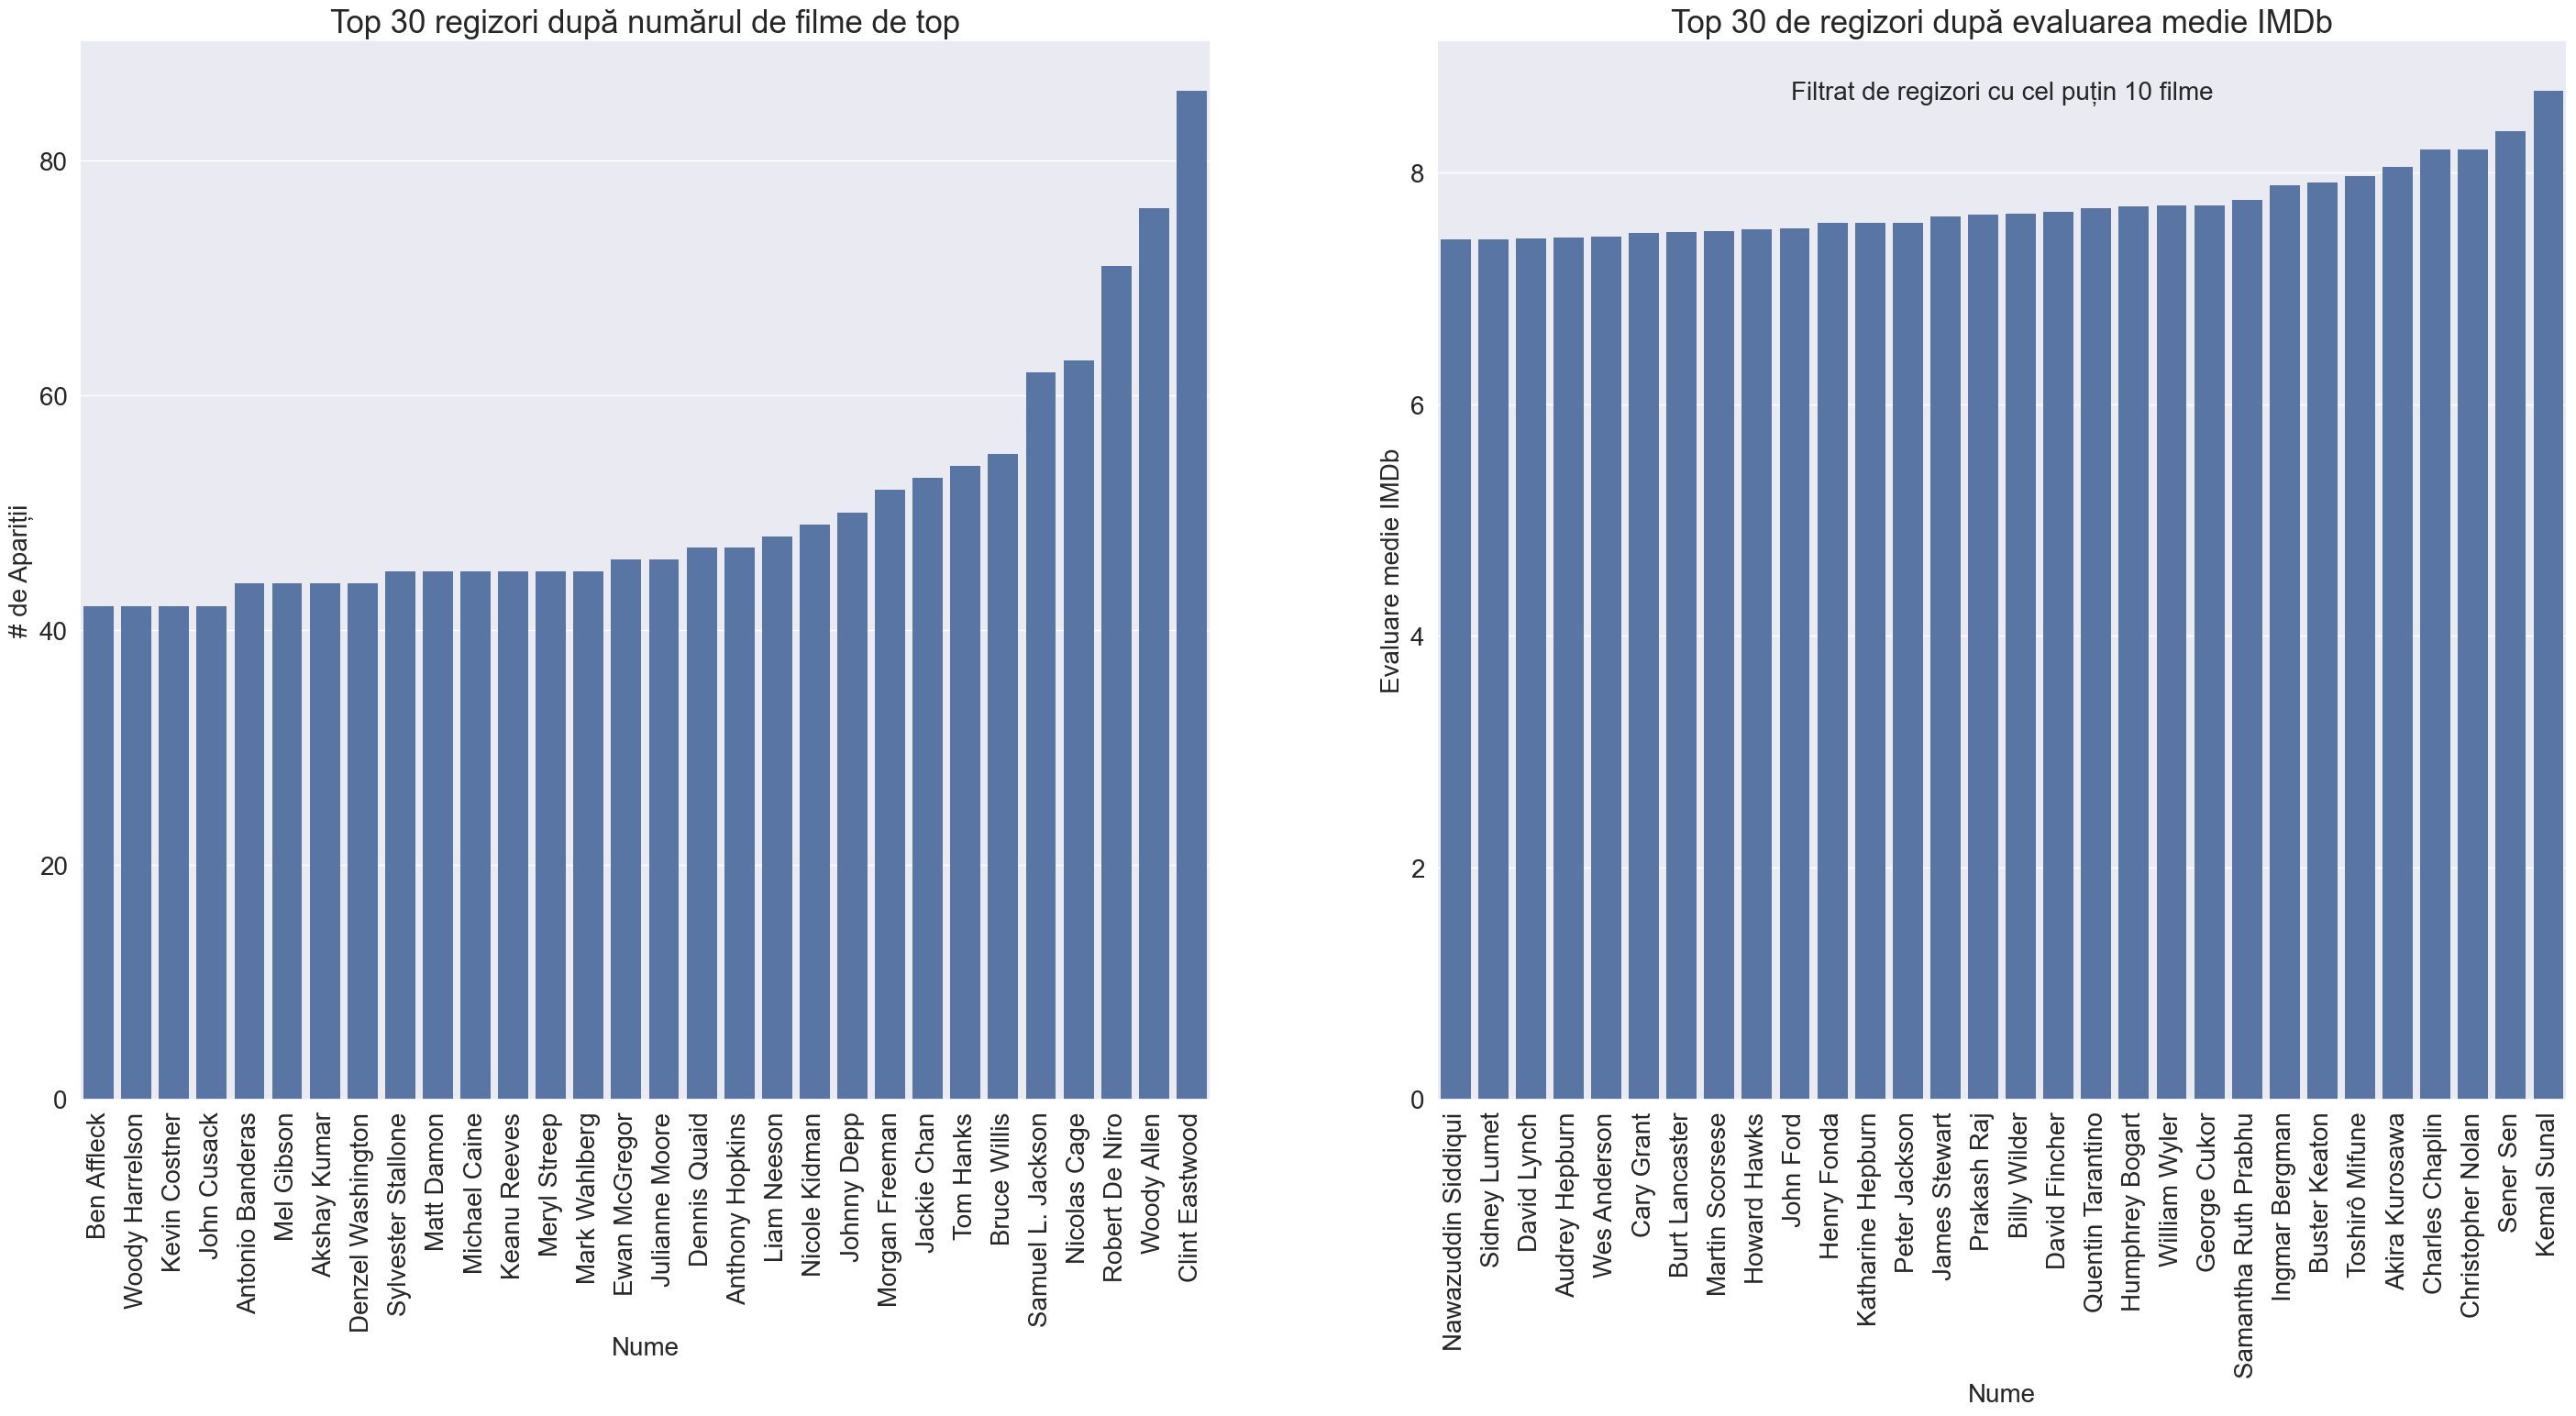

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(35, 15), gridspec_kw={'hspace': 0.5})

sns.barplot(x = dir_order[-30:].index, y = dir_order[-30:], ax=axes[0])
sns.barplot(data=dir_df[-30:], x='director', y='avg_rating', ax=axes[1])

axes[0].tick_params(axis='x', rotation=90, labelsize=20)
axes[1].tick_params(axis='x', rotation=90, labelsize=20)

axes[0].tick_params(axis='y', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)

axes[0].set_xlabel('Nume', fontsize=20)
axes[0].set_ylabel('# de Apariții', fontsize=20)
axes[0].set_title('Top 30 regizori după numărul de filme de top', fontsize=25)

axes[1].set_xlabel('Nume', fontsize=20)
axes[1].set_ylabel('Evaluare medie IMDb', fontsize=20)
axes[1].set_title('Top 30 de regizori după evaluarea medie IMDb', fontsize=25)
axes[1].text(0.5, 0.95, 'Filtrat de regizori cu cel puțin 10 filme', ha='center', va='center',
             transform=axes[1].transAxes, fontsize=20)

plt.show()

**Filmele populare sunt evaluate mai bine?**

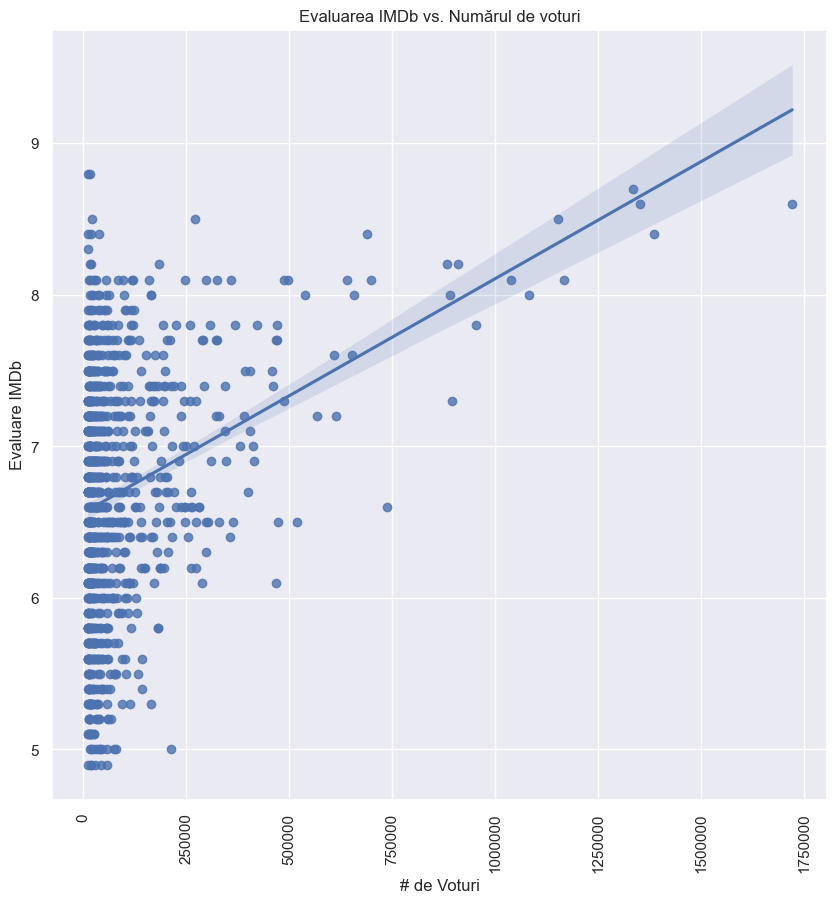

In [63]:
pop_sample = movies_df.sample(n=sample_size)
pop_scatterplot=sns.regplot(data=pop_sample, x='votes', y='rating')

pop_scatterplot.set(xlabel='# de Voturi',
                    ylabel='Evaluare IMDb',
                    title='Evaluarea IMDb vs. Numărul de voturi')
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='x')